<a href="https://colab.research.google.com/github/stewieboomhauer/BSNLP-SlavNER-shared-task-2021-with-Spacy-v3-main/blob/main/Lidl_Analytics_%E2%80%93_Erweiterung_des_S%C3%BC%C3%9Fwarensortiments_(Eigenmarke).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pandas import DataFrame

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from math import sqrt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import xgboost

-------------------------------------------------------
# **1. Loading Data and First General Info**
-------------------------------------------------------


In [ ]:
!git clone https://github.com/fivethirtyeight/data.git

fatal: destination path 'data' already exists and is not an empty directory.


In [ ]:
# Load the data
df = pd.read_csv("/content/data/candy-power-ranking/candy-data.csv")

In [ ]:
#General Info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


In [ ]:
#Characteristics of the non-binary features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
chocolate,85.0,0.435294,0.498738,0.000000,0.000000,0.000000,1.000000,1.00000
fruity,85.0,0.447059,0.500140,0.000000,0.000000,0.000000,1.000000,1.00000
caramel,85.0,0.164706,0.373116,0.000000,0.000000,0.000000,0.000000,1.00000
peanutyalmondy,85.0,0.164706,0.373116,0.000000,0.000000,0.000000,0.000000,1.00000
nougat,85.0,0.082353,0.276533,0.000000,0.000000,0.000000,0.000000,1.00000
crispedricewafer,85.0,0.082353,0.276533,0.000000,0.000000,0.000000,0.000000,1.00000
hard,85.0,0.176471,0.383482,0.000000,0.000000,0.000000,0.000000,1.00000
bar,85.0,0.247059,0.433861,0.000000,0.000000,0.000000,0.000000,1.00000
pluribus,85.0,0.517647,0.502654,0.000000,0.000000,1.000000,1.000000,1.00000
sugarpercent,85.0,0.478647,0.282778,0.011000,0.220000,0.465000,0.732000,0.98800


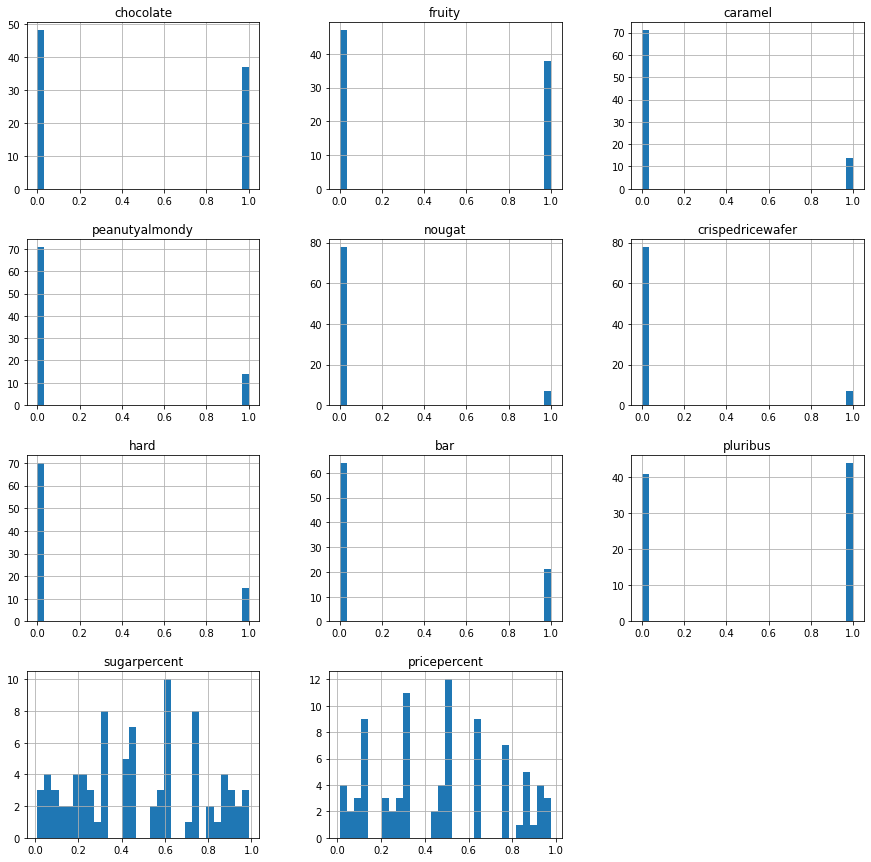

In [ ]:
#Plot the features
df[df.columns[1:-1]].hist(bins=30, figsize=(15, 15))
plt.show()

In [ ]:
'Count Candys with Chocolate and other factors'
features=df.columns[2:-3]
for elem in features:
  print('Amount of Candys with Chocolate and', elem.capitalize(),'\n')
  print(df.groupby(['chocolate',elem])['competitorname'].count().reset_index())
  print()

Amount of Candys with Chocolate and Fruity 

   chocolate  fruity  competitorname
0          0       0              11
1          0       1              37
2          1       0              36
3          1       1               1

Amount of Candys with Chocolate and Caramel 

   chocolate  caramel  competitorname
0          0        0              44
1          0        1               4
2          1        0              27
3          1        1              10

Amount of Candys with Chocolate and Peanutyalmondy 

   chocolate  peanutyalmondy  competitorname
0          0               0              46
1          0               1               2
2          1               0              25
3          1               1              12

Amount of Candys with Chocolate and Nougat 

   chocolate  nougat  competitorname
0          0       0              47
1          0       1               1
2          1       0              31
3          1       1               6

Amount of Candys with 

In [ ]:
print(df.groupby(['chocolate','peanutyalmondy','caramel'])['competitorname'].count().reset_index())

   chocolate  peanutyalmondy  caramel  competitorname
0          0               0        0              42
1          0               0        1               4
2          0               1        0               2
3          1               0        0              18
4          1               0        1               7
5          1               1        0               9
6          1               1        1               3


In [ ]:
print(df.groupby(['chocolate','crispedricewafer','caramel'])['competitorname'].count().reset_index())

   chocolate  crispedricewafer  caramel  competitorname
0          0                 0        0              44
1          0                 0        1               4
2          1                 0        0              23
3          1                 0        1               7
4          1                 1        0               4
5          1                 1        1               3


In [ ]:
print(df.groupby(['chocolate','peanutyalmondy','crispedricewafer'])['competitorname'].count().reset_index())

   chocolate  peanutyalmondy  crispedricewafer  competitorname
0          0               0                 0              46
1          0               1                 0               2
2          1               0                 0              19
3          1               0                 1               6
4          1               1                 0              11
5          1               1                 1               1


In [ ]:
print(df.groupby(['chocolate','peanutyalmondy','nougat'])['competitorname'].count().reset_index())

   chocolate  peanutyalmondy  nougat  competitorname
0          0               0       0              46
1          0               1       0               1
2          0               1       1               1
3          1               0       0              21
4          1               0       1               4
5          1               1       0              10
6          1               1       1               2


In [ ]:
#Check the best Candys
df_20best= df.sort_values('winpercent', ascending=False)[:20]


In [ ]:
df_20best

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
52,Reese's Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,84.180290
51,Reese's Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,81.866257
79,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,81.642914
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
64,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782
53,Reese's pieces,1,0,0,1,0,0,0,0,1,0.406,0.651,73.434990
36,Milky Way,1,0,1,0,1,0,0,1,0,0.604,0.651,73.099556
54,Reese's stuffed with pieces,1,0,0,1,0,0,0,0,0,0.988,0.651,72.887901
32,Peanut butter M&M's,1,0,0,1,0,0,0,0,1,0.825,0.651,71.465050
42,Nestle Butterfinger,1,0,0,1,0,0,0,1,0,0.604,0.767,70.735641


In [ ]:
df_20best.describe().T

,count,mean,std,min,25%,50%,75%,max
chocolate,20.0,0.900000,0.307794,0.000000,1.000000,1.000000,1.000000,1.00000
fruity,20.0,0.100000,0.307794,0.000000,0.000000,0.000000,0.000000,1.00000
caramel,20.0,0.300000,0.470162,0.000000,0.000000,0.000000,1.000000,1.00000
peanutyalmondy,20.0,0.400000,0.502625,0.000000,0.000000,0.000000,1.000000,1.00000
nougat,20.0,0.150000,0.366348,0.000000,0.000000,0.000000,0.000000,1.00000
crispedricewafer,20.0,0.250000,0.444262,0.000000,0.000000,0.000000,0.250000,1.00000
hard,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
bar,20.0,0.500000,0.512989,0.000000,0.000000,0.500000,1.000000,1.00000
pluribus,20.0,0.350000,0.489360,0.000000,0.000000,0.000000,1.000000,1.00000
sugarpercent,20.0,0.600000,0.267531,0.034000,0.424000,0.604000,0.825000,0.98800


In [ ]:
#1 if quality of candy more or equals 62 
df['best candy'] = [ 1 if x>=62 else 0 for x in df.winpercent] 

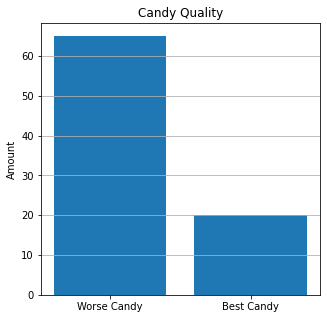

In [ ]:
label = ('Worse Candy', 'Best Candy')
freq = df['best candy'].value_counts().sort_index()

fig,ax = plt.subplots(figsize=(5,5))

plt.bar(label, freq, align='center')
plt.ylabel('Amount')
plt.title('Candy Quality')
plt.grid(axis = 'y')

plt.show()

------------------------------------------
# **2. Preprocessing**

------------------------------------------
* Check if there are missing values
* Check if there are duplicates in the dataset
* Delete all duplicates
* Check if there are correlated features in the dataset
* Delete all correlated Features

------------------------------------------

In [ ]:
# Check if there are missing values in the dataset
df.isnull().sum()

competitorname      0
chocolate           0
fruity              0
caramel             0
peanutyalmondy      0
nougat              0
crispedricewafer    0
hard                0
bar                 0
pluribus            0
sugarpercent        0
pricepercent        0
winpercent          0
best candy          0
dtype: int64

In [ ]:
# Check for Duplicate Value
df.duplicated().sum()


0

In [ ]:
df=df.drop(['best candy'], axis=1)

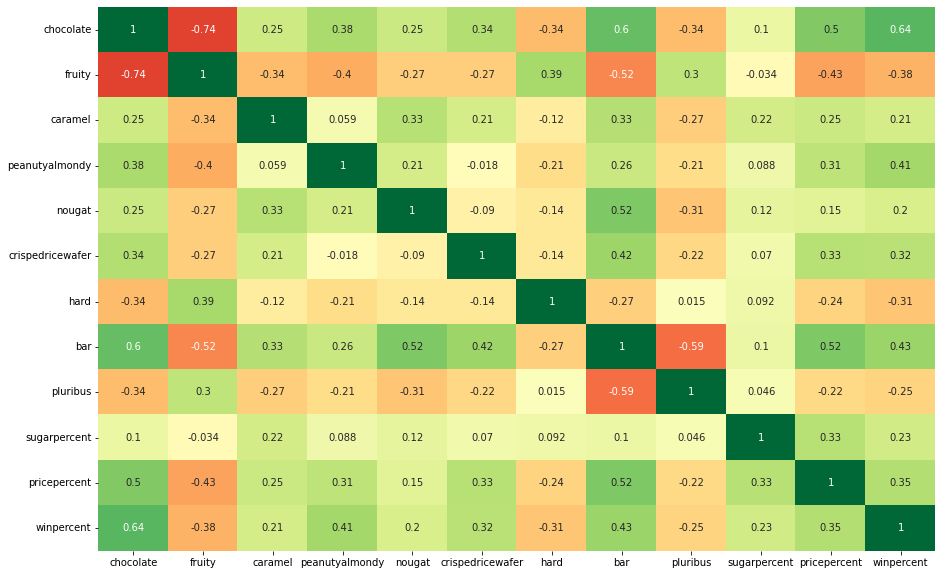

In [ ]:
#Plot Correlation matrix to find correlated features
plt.figure(figsize=(15, 10))
sb.heatmap(df.corr(), annot=True, cbar=False, center=0, cmap="RdYlGn")
plt.show()


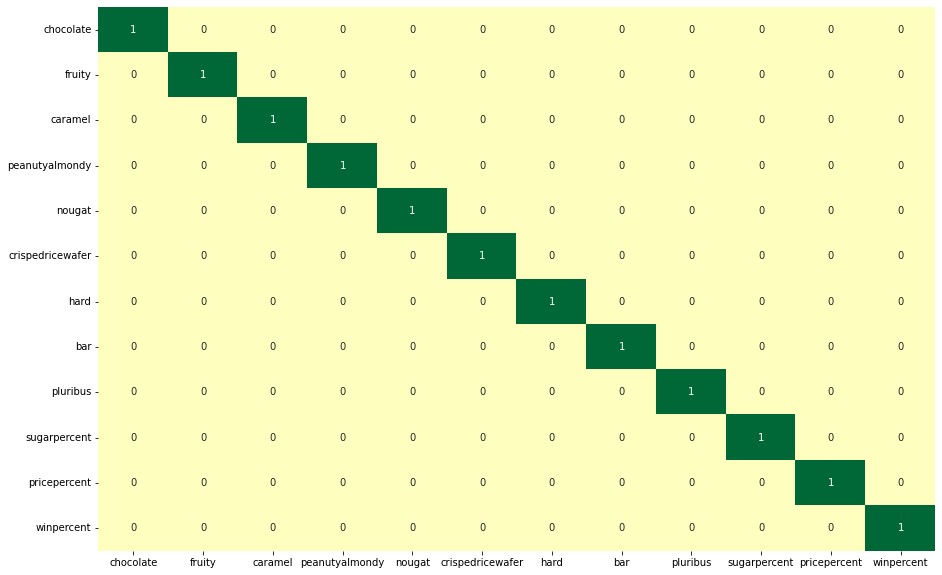

In [ ]:
#Plot correltion matrix with correlation higher than 0.7
plt.figure(figsize=(15, 10))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False, center=0, cmap="RdYlGn")
plt.show()

------------------------------------------
# **3. Analyse**

## **3.1 Feature Importance with Machine Learning Models**

In [ ]:
X=df[df.columns[1:-2]]
y=df[['winpercent']]

In [ ]:
param_grid = dict(
    max_depth=[3, 4, 5], 
    learning_rate=[0.05, 0.1, 0.2], 
    n_estimators=[32, 33, 34],
    min_child_weight=[5, 6, 7],
    subsample=[0.4, 0.5, 0.6],
)

clf_xgb = xgboost.XGBRegressor(objective='reg:squarederror')
model_xgb = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, n_jobs=4, refit=True, cv=4, scoring='r2')

model_xgb.fit(X, y)


GridSearchCV(cv=4, estimator=XGBRegressor(objective='reg:squarederror'),
             n_jobs=4,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [5, 6, 7],
                         'n_estimators': [32, 33, 34],
                         'subsample': [0.4, 0.5, 0.6]},
             scoring='r2')

[Text(0.5, 1.0, 'Feature Importance with XGBRegressor')]

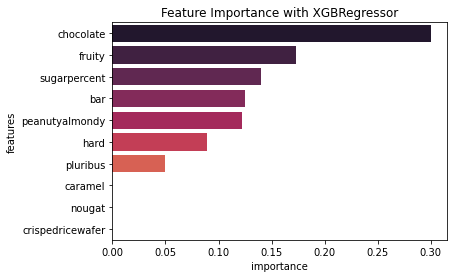

In [ ]:
imp = pd.DataFrame({'features': df.columns[1:-2], 'importance': model_xgb.best_estimator_.feature_importances_})
imp.sort_values('importance', ascending=False, inplace=True)
sb.barplot(x='importance', y='features', data=imp, palette='rocket').set(title='Feature Importance with XGBRegressor')

In [ ]:
param_grid = {
    'max_depth': [None, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [6, 7, 8, 9],
    'min_samples_split': [10, 11, 12, 13],
    'n_estimators': [130, 140, 150, 160]
}

clf_rf = RandomForestRegressor()
model_rf = GridSearchCV(estimator=clf_rf, param_grid=param_grid, n_jobs=4, refit=True, cv=4, scoring='r2')

model_rf.fit(X, np.ravel(y))

GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [None, 10, 15, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [6, 7, 8, 9],
                         'min_samples_split': [10, 11, 12, 13],
                         'n_estimators': [130, 140, 150, 160]},
             scoring='r2')

[Text(0.5, 1.0, 'Feature Importance with Random Forest Regressor')]

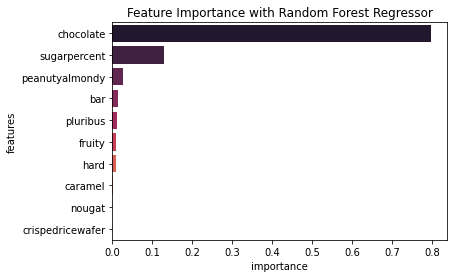

In [ ]:
imp = pd.DataFrame({'features': df.columns[1:-2], 'importance': model_rf.best_estimator_.feature_importances_})
imp.sort_values('importance', ascending=False, inplace=True)
sb.barplot(x='importance', y='features', data=imp, palette="rocket").set(title='Feature Importance with Random Forest Regressor')

In [ ]:
from sklearn.tree import DecisionTreeRegressor
param_grid = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
model_decTree = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, verbose=1, cv=3)
model_decTree.fit(X, np.ravel(y))

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

[Text(0.5, 1.0, 'Feature Importance with Decision Tree Regressor')]

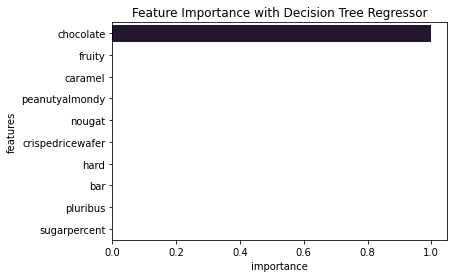

In [ ]:
imp = pd.DataFrame({'features': df.columns[1:-2], 'importance': model_decTree.best_estimator_.feature_importances_})
imp.sort_values('importance', ascending=False, inplace=True)
sb.barplot(x='importance', y='features', data=imp, palette="rocket").set(title='Feature Importance with Decision Tree Regressor')

## **3.2 Feature Importance. Univariate Analysis**

------------------------------------------
* Check if there is significant influence of categorical values (sugar percent and price percent) on win percent

------------------------------------------

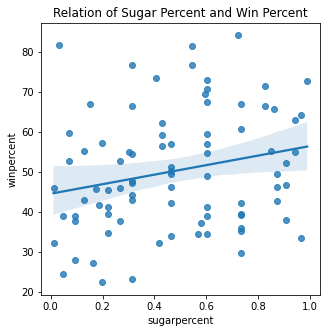

In [ ]:
#Plot Relation of Sugar Percent and Win Percent
plt.figure(figsize=(5,5))
sb.regplot(data=df, x='sugarpercent', y='winpercent').set_title('Relation of Sugar Percent and Win Percent',fontsize=12);

In [ ]:
#Pearson's correlation coefficient
df_sugar = pd.DataFrame({'win': df['winpercent']/100,'sugar': df['sugarpercent']})
df_sugar.corr()

,win,sugar
win,1.000000,0.229151
sugar,0.229151,1.000000


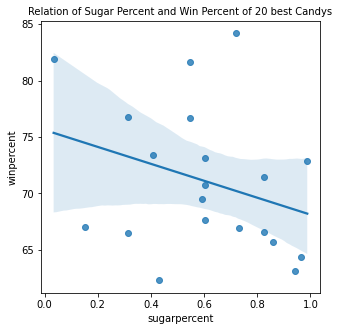

In [ ]:
#Relation of Sugar Percent and Win Percent for 20 best Candys
plt.figure(figsize=(5,5))
sb.regplot(data=df_20best, x='sugarpercent', y='winpercent').set_title('Relation of Sugar Percent and Win Percent of 20 best Candys',fontsize=10);

In [ ]:
#Pearson's correlation coefficient of 20 best candys
df_sugar = pd.DataFrame({'win': df_20best['winpercent']/100,'sugar': df_20best['sugarpercent']})
df_sugar.corr()

,win,sugar
win,1.000000,-0.313037
sugar,-0.313037,1.000000


<Figure size 1080x1080 with 0 Axes>

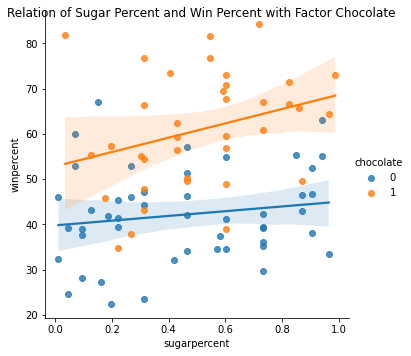

In [ ]:
#Plot Relation of Sugar Percent and Win Percent with Factor Chocolate
plt.figure(figsize=(15,15))
plot =sb.lmplot(data=df, x='sugarpercent', y='winpercent', hue='chocolate');
plot.fig.suptitle('Relation of Sugar Percent and Win Percent with Factor Chocolate',fontsize=12);

<Figure size 720x720 with 0 Axes>

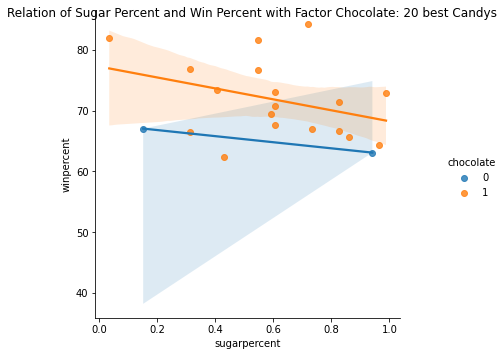

In [ ]:
#Plot Relation of Sugar Percent and Win Percent with Factor Chocolate: 20 best Candys
plt.figure(figsize=(10,10))
plot =sb.lmplot(data=df_20best, x='sugarpercent', y='winpercent', hue='chocolate');
plot.fig.suptitle('Relation of Sugar Percent and Win Percent with Factor Chocolate: 20 best Candys',fontsize=12);

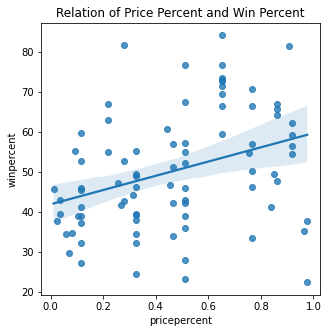

In [ ]:
#Plot Relation of Price Percent and Win Percent
plt.figure(figsize=(5,5))
sb.regplot(data=df, x='pricepercent', y='winpercent').set_title(f'Relation of Price Percent and Win Percent',fontsize=12);

In [ ]:
#Pearson's correlation coefficient for price
df_price = pd.DataFrame({'win': df['winpercent']/100,'price': df['pricepercent']})
df_price.corr()

,win,price
win,1.000000,0.345325
price,0.345325,1.000000


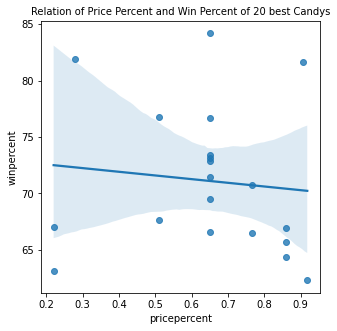

In [ ]:
#Plot Relation of Price Percent and Win Percent of 20 best Candys
plt.figure(figsize=(5,5))
sb.regplot(data=df_20best, x='pricepercent', y='winpercent').set_title('Relation of Price Percent and Win Percent of 20 best Candys',fontsize=10);

In [ ]:
#Pearson's correlation coefficient for price
df_price = pd.DataFrame({'win': df_20best['winpercent']/100,'price': df_20best['pricepercent']})
df_price.corr()

,win,price
win,1.000000,-0.106979
price,-0.106979,1.000000


<Figure size 1080x1080 with 0 Axes>

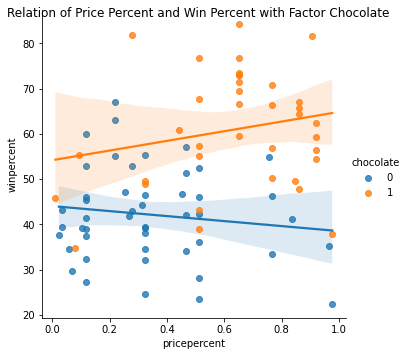

In [ ]:
#Plot Relation of Price Percent and Win Percent with Factor Chocolate
plt.figure(figsize=(15,15))
plot =sb.lmplot(data=df, x='pricepercent', y='winpercent', hue='chocolate');
plot.fig.suptitle('Relation of Price Percent and Win Percent with Factor Chocolate',fontsize=12);

------------------------------------------
* Check if there is significant influence of binary values on win percent

------------------------------------------

In [ ]:
def analyze_factors(data, name):
  plt.figure(figsize=(10,10))
  plt.suptitle(f"{name.capitalize()} Plots", fontsize=20)
  plt.subplot(2, 2, 1)
  sb.boxplot(x=name, y="winpercent", data=df).set_title(f'Relation of {name.capitalize()} and Win Percent',fontsize=12);
  
  plt.subplot(2, 2, 2)
  sb.boxplot(y="pricepercent", x=f"{name}", data=data).set_title(f"Price percentage with and without {name.capitalize()}",fontsize=12);
    
  plt.subplot(2, 2, 3)
  sb.boxplot(y="sugarpercent", x=f"{name}", data=data).set_title(f"Sugar percentage with and without {name.capitalize()}",fontsize=12);

  plt.subplot(2, 2, 4)
  plt.title(f"Total percentage of Candies with and without {name.capitalize()}",fontsize=12)
  plt.pie(data[name].value_counts(), autopct='%1.1f%%',labels=[f"{name.capitalize()}",f"Not {name.capitalize()}"])

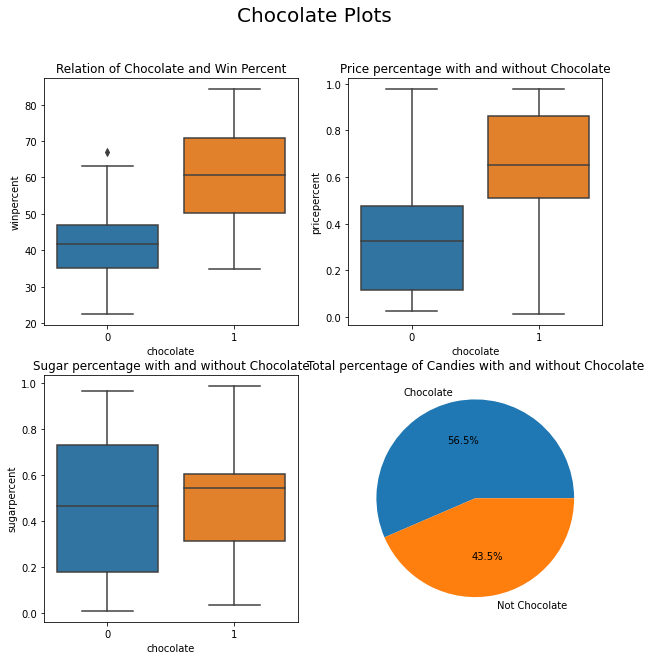

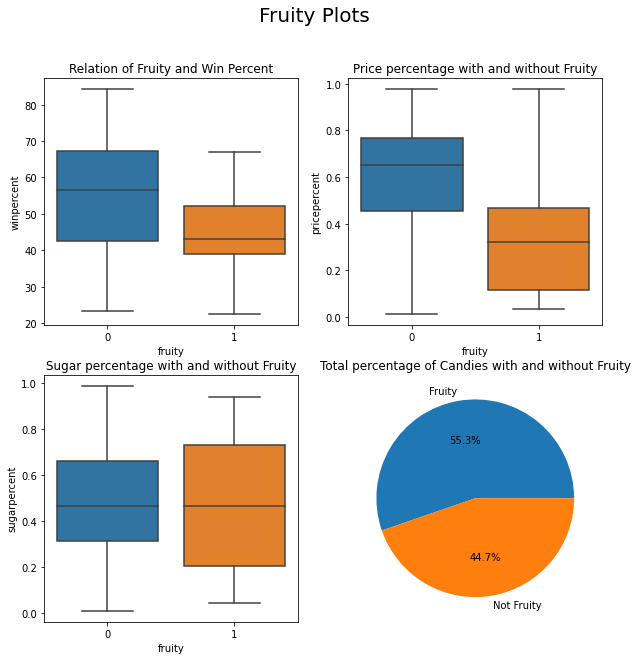

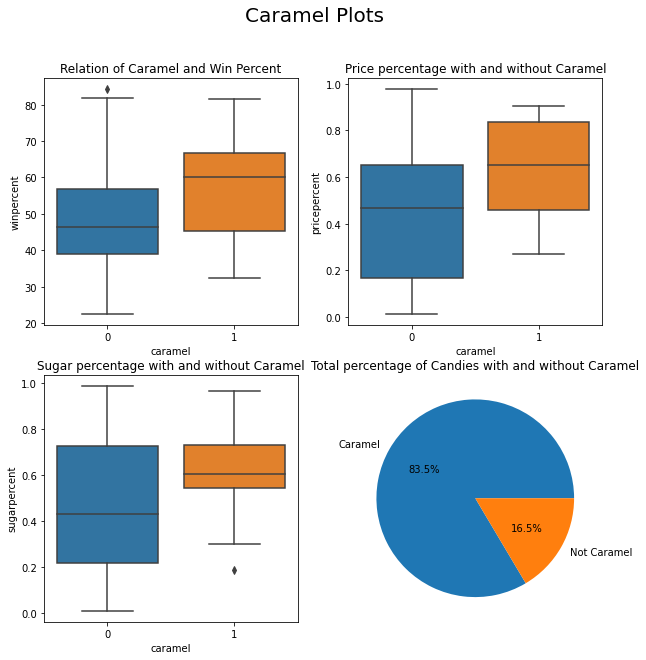

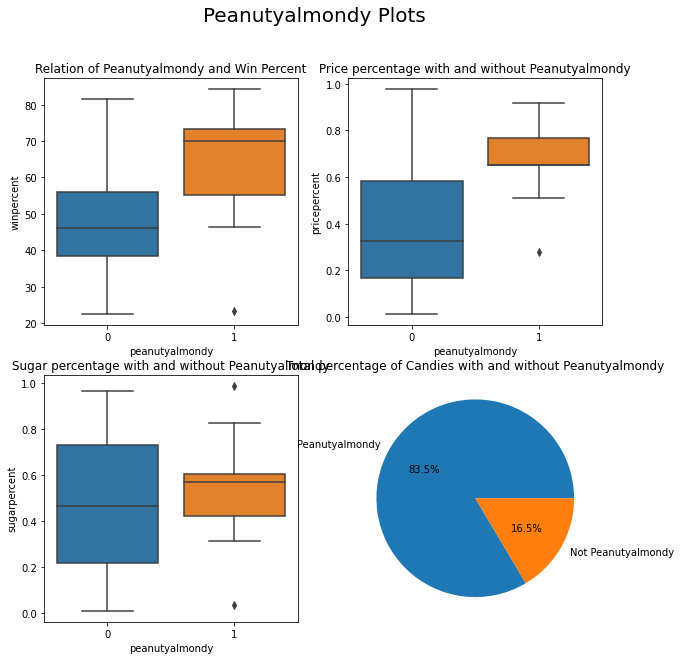

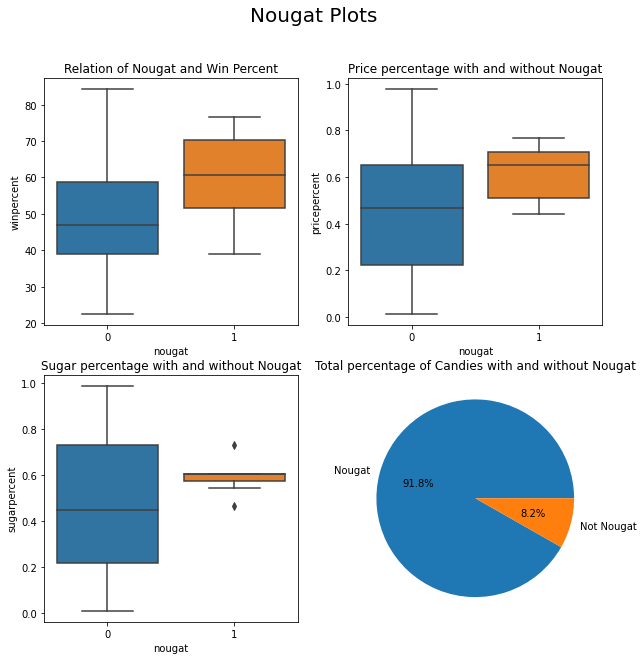

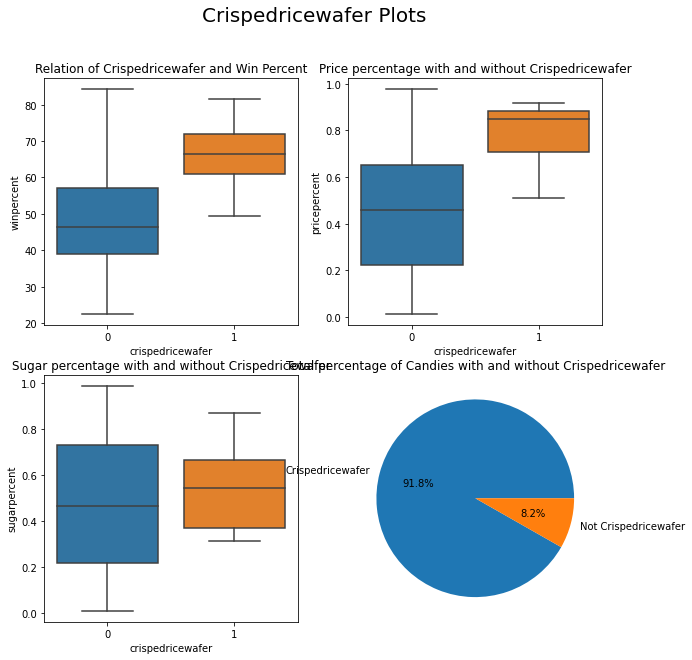

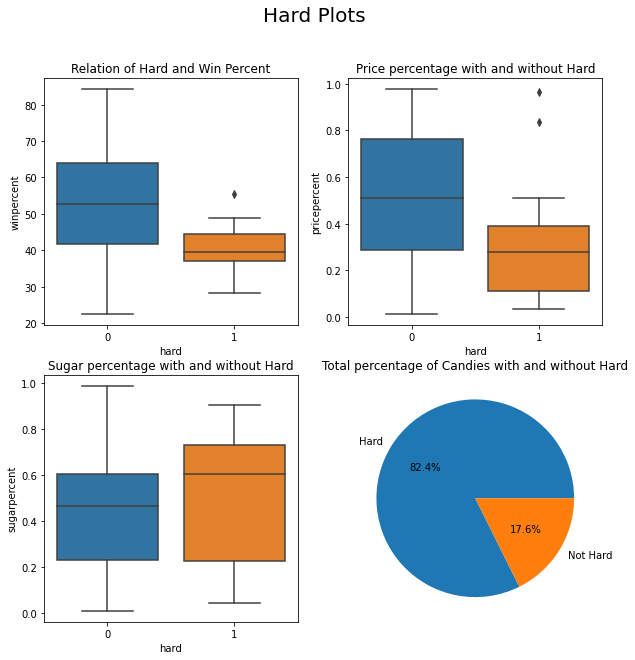

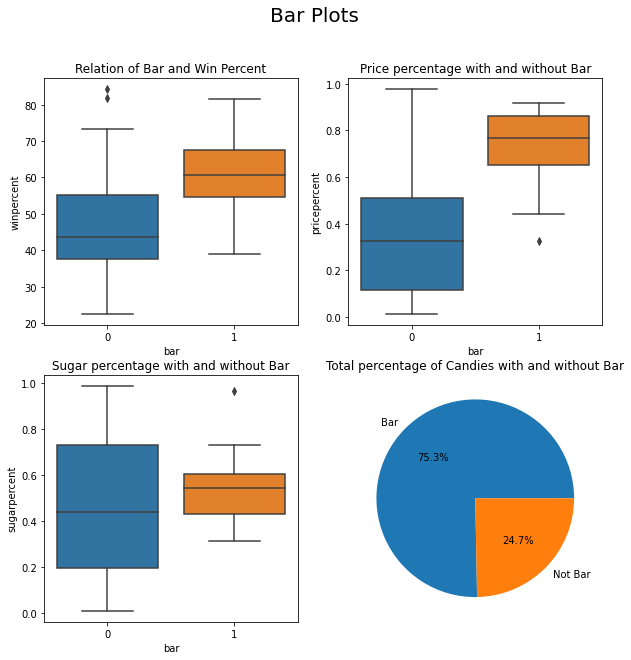

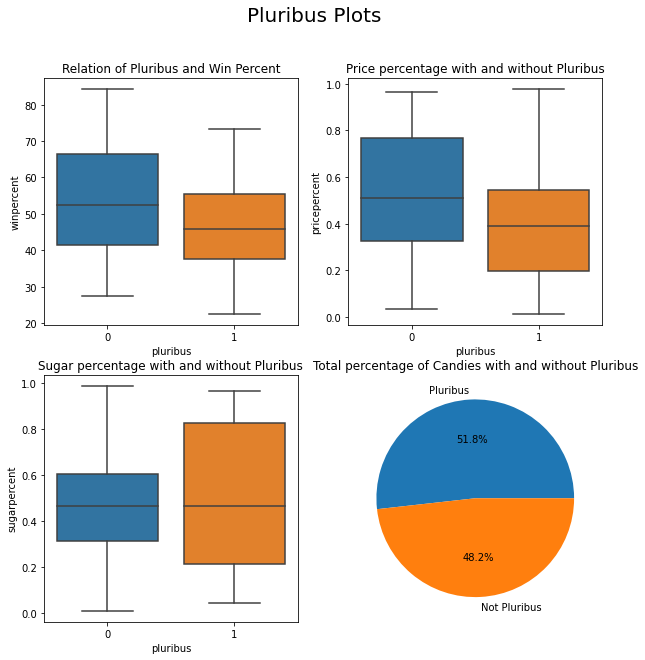

In [ ]:
features=df.columns[1:-3]
for elem in features:
  analyze_factors(df, elem)

------------------------------------------
* Check if there is significant influence of combination of features on win percent

------------------------------------------

In [ ]:
combi_choc_caram_peanut = pd.pivot_table(df,
               values=['winpercent'],
               index=['chocolate', 'peanutyalmondy', 'caramel'],
               aggfunc='mean',
               fill_value=0
              ).reset_index()

In [ ]:
combi_choc_caram_peanut

,chocolate,peanutyalmondy,caramel,winpercent
0,0,0,0,43.119604
1,0,0,1,35.522633
2,0,1,0,34.857211
3,1,0,0,53.577917
4,1,0,1,66.806942
5,1,1,0,69.880879
6,1,1,1,64.372527


In [ ]:
combi_choc_caram = pd.pivot_table(df,
               values=['winpercent'],
               index=['chocolate', 'caramel'],
               aggfunc='mean',
               fill_value=0
              ).reset_index()

In [ ]:
combi_choc_caram

,chocolate,caramel,winpercent
0,0,0,42.744041
1,0,1,35.522633
2,1,0,59.012238
3,1,1,66.076617


In [ ]:
combi_choc_peanut = pd.pivot_table(df,
               values=['winpercent'],
               index=['chocolate', 'peanutyalmondy'],
               aggfunc='mean',
               fill_value=0
              ).reset_index()

In [ ]:
combi_choc_peanut

,chocolate,peanutyalmondy,winpercent
0,0,0,42.458998
1,0,1,34.857211
2,1,0,57.282044
3,1,1,68.503791


In [ ]:
combi_choc_peanut_crisp = pd.pivot_table(df,
               values=['winpercent'],
               index=['chocolate', 'peanutyalmondy', 'crispedricewafer'],
               aggfunc='mean',
               fill_value=0
              ).reset_index()

In [ ]:
combi_choc_peanut_crisp

,chocolate,peanutyalmondy,crispedricewafer,winpercent
0,0,0,0,42.458998
1,0,1,0,34.857211
2,1,0,0,54.125715
3,1,0,1,67.277085
4,1,1,0,69.319658
5,1,1,1,59.529251


In [ ]:
super_combi = pd.pivot_table(df,
               values=['winpercent'],
               index=['chocolate', 'peanutyalmondy', 'crispedricewafer', 'caramel', 'bar'],
               aggfunc='mean',
               fill_value=0
              ).reset_index().sort_values('winpercent', ascending=False)

In [ ]:
super_combi

,chocolate,peanutyalmondy,crispedricewafer,caramel,bar,winpercent
11,1,1,0,0,0,75.553046
10,1,0,1,1,1,74.307320
9,1,0,1,0,1,68.507920
13,1,1,0,1,1,66.794164
7,1,0,0,1,1,66.084532
6,1,0,0,1,0,60.390179
14,1,1,1,1,1,59.529251
12,1,1,0,0,1,58.536546
5,1,0,0,0,1,53.297975
8,1,0,1,0,0,49.524113


In [ ]:
super_combi[super_combi.winpercent > 63]

,chocolate,peanutyalmondy,crispedricewafer,caramel,bar,winpercent
11,1,1,0,0,0,75.553046
10,1,0,1,1,1,74.307320
9,1,0,1,0,1,68.507920
13,1,1,0,1,1,66.794164
7,1,0,0,1,1,66.084532
